In [18]:
!pip install bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00


In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.data import shepp_logan_phantom
from tqdm.notebook import tqdm
import bm3d

## Q3

In [35]:
def get_shepp_logan_phantom(size=None):
    if size is not None:
        phantom_image = shepp_logan_phantom()
        modified_phantom_image = cv2.resize(phantom_image, size)
    else:
        modified_phantom_image = shepp_logan_phantom()
    return (modified_phantom_image * 255).astype(np.uint8)


def add_gaussian_noise(img, mu=0, var=0.3):
    img = img.astype(np.float64)
    img /= np.max(img)
    gaussian_noise = np.zeros_like(img)
    gaussian_noise = cv2.randn(gaussian_noise, mu, np.sqrt(var))
    noisy_img = cv2.add(img, gaussian_noise)
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 1] = 1
    return (255 * noisy_img).astype(np.uint8)

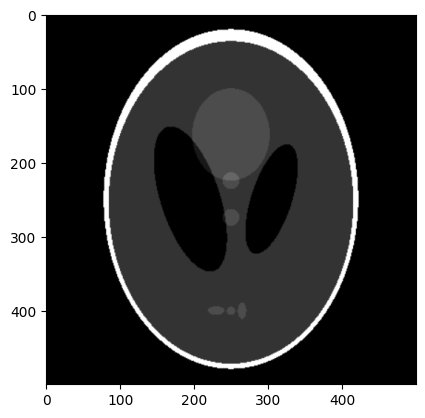

In [33]:
modified_phantom_image = get_shepp_logan_phantom((500, 500))
plt.imshow(modified_phantom_image, 'gray')
plt.show()

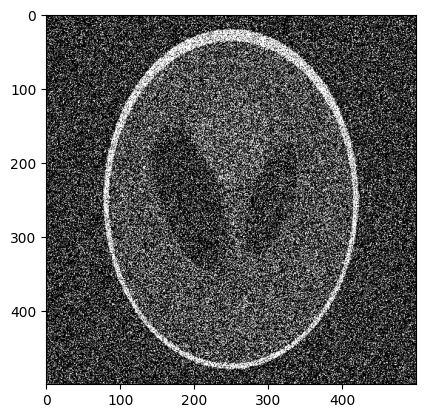

In [36]:
noisy_phantom = add_gaussian_noise(modified_phantom_image, 0, 0.3)
plt.imshow(noisy_phantom, cmap='gray')
plt.show()

### LWM

In [30]:
def create_Ghx(kernel_size, hx):
    Ghx = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            Ghx[i, j] = (i - kernel_size // 2) ** 2 + (j - kernel_size // 2) ** 2

    Ghx = np.exp(-Ghx / (2 * hx ** 2))
    return Ghx

def filter_img(img, kernel):
    norm = np.sum(kernel)
    kernel = kernel / norm
    filtered_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return filtered_img

def PSNR(img1, img2, max_pixel_value=255):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

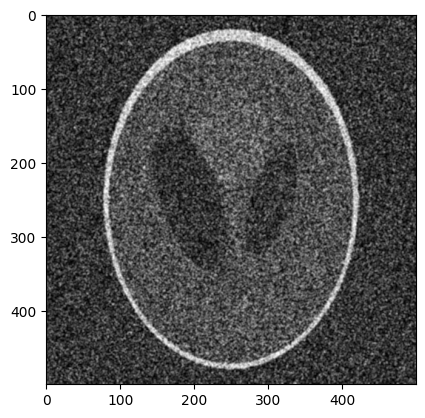

In [66]:
hx = 0.02 * modified_phantom_image.shape[0]
Ghx = create_Ghx(3, hx)
filtered_img = filter_img(noisy_phantom, Ghx)
plt.imshow(filtered_img, 'gray')
plt.show()

One of the main disadvantages of local weighted mean (LWM) is that it can be sensitive to the choice of window size and weighting function. The choice of window size can significantly impact the quality of the resulting image, with smaller window sizes leading to more localized smoothing and larger window sizes leading to more global smoothing. Similarly, the choice of weighting function can affect the trade-off between preserving sharp edges in the image and smoothing out noise.

In [42]:
print(f'PSNR of noisy image:\t\t\t{PSNR(noisy_phantom, modified_phantom_image)}')
print(f'PSNR of denoised image by LWM:\t\t{PSNR(filtered_img, modified_phantom_image)}')

PSNR of noisy image:			8.783830646133111
PSNR of denoised image by LWM:		13.584172389766092


### BM3D

The basic idea behind BM3D is to divide the image into overlapping blocks and then group similar blocks together using a 3D transform. The 3D transform takes into account both the spatial and the frequency domains of the image, allowing for more effective noise removal. The grouped blocks are then processed using a collaborative filtering step, which involves averaging the blocks and then applying a Wiener filter to the resulting image.

The BM3D algorithm can be summarized in the following steps:


1.   Divide the image into overlapping blocks.
2.   For each block, find similar blocks in the image using block matching.
3.   Apply a 3D transform to the group of similar blocks, which takes into account both the spatial and the frequency domains of the image.
4.   Apply a collaborative filtering step to the 3D transformed blocks, which involves averaging the blocks and then applying a Wiener filter to the resulting image.
5.   Combine the filtered blocks to produce the denoised image.

The BM3D algorithm has been shown to be effective at removing a variety of noise types, including Gaussian noise, impulsive noise, and mixed noise. It has also been extended to handle color images and videos.

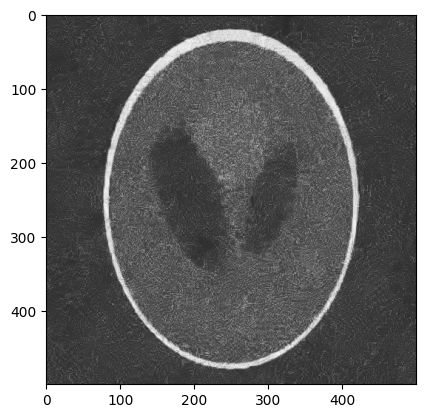

In [85]:
denoised_image = bm3d.bm3d(noisy_phantom, sigma_psd=60, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
plt.imshow(denoised_image, 'gray')
plt.show()

In [86]:
print(f'PSNR of noisy image:\t\t\t{PSNR(noisy_phantom, modified_phantom_image)}')
print(f'PSNR of denoised image by LWM:\t\t{PSNR(filtered_img, modified_phantom_image)}')
print(f'PSNR of denoised image by BM3D:\t\t{PSNR(denoised_image, modified_phantom_image)}')

PSNR of noisy image:			8.783830646133111
PSNR of denoised image by LWM:		13.521689069988298
PSNR of denoised image by BM3D:		15.146444608292999
